In [1]:
!pip install pandas seaborn scikit-learn

# Домашнее задание 3

1. Выбрать номинальное значение как целевую переменную
2. Провести разведочный анализ **включая** анализ зависимости между номинальными переменными (chi2)
3. Выбрать `best_features`
4. Сделать нормализацию данных (scaler, onehotencoding)
4. Обучить модель логистической регрессии
5. Вывести метрики качества, описать полученный результат (также вывести коэфициенты модели)

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('student_performance.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   student_id               1000000 non-null  int64  
 1   weekly_self_study_hours  1000000 non-null  float64
 2   attendance_percentage    1000000 non-null  float64
 3   class_participation      1000000 non-null  float64
 4   total_score              1000000 non-null  float64
 5   grade                    1000000 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 45.8+ MB


In [5]:
df['grade'] = df['grade'].astype('category')

### EDA

In [6]:
import numpy as np

median_score = df['total_score'].median()
df['score_level'] = np.where(df['total_score'] > median_score, 'high', 'low')

In [7]:
median_score = df['attendance_percentage'].median()
df['attendance_level'] = np.where(df['attendance_percentage'] > median_score, 'high', 'low')

In [8]:
median_score = df['weekly_self_study_hours'].median()
df['study_level'] = np.where(df['weekly_self_study_hours'] > median_score, 'high', 'low')

In [9]:
median_score = df['class_participation'].median()
df['participation_level'] = np.where(df['class_participation'] > median_score, 'high', 'low')

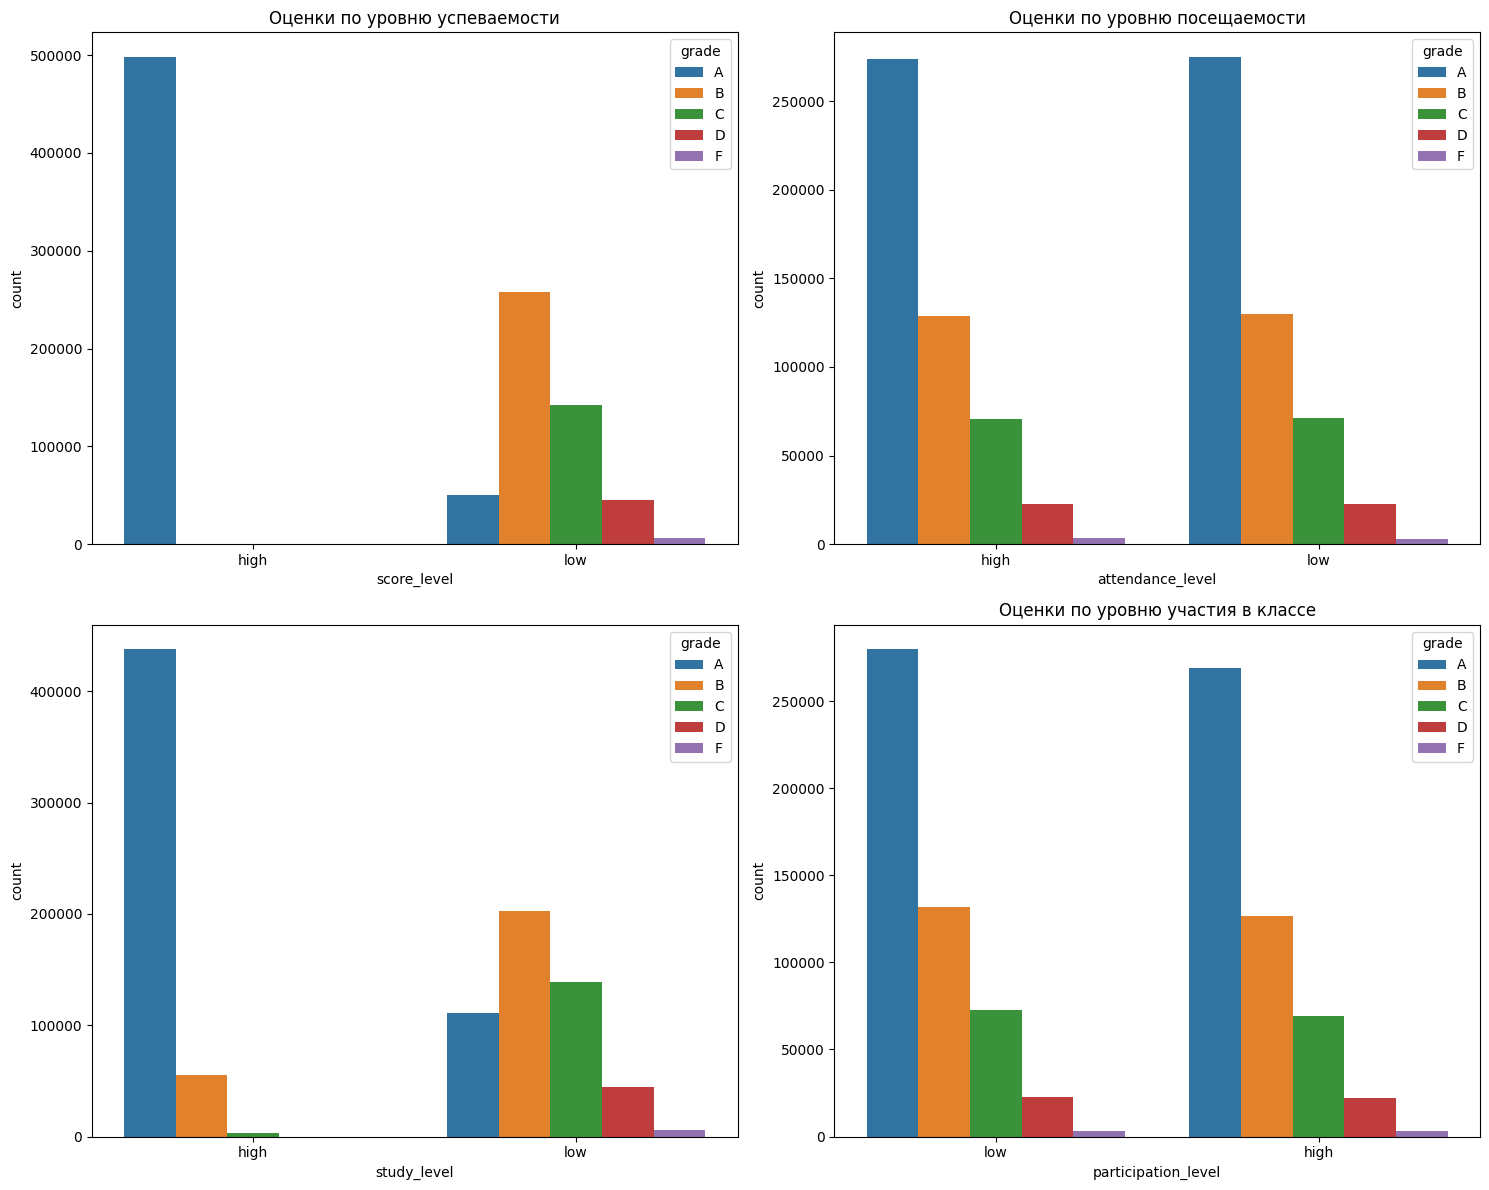

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

sns.countplot(data=df, x='score_level', hue='grade', ax=axes[0,0])
axes[0,0].set_title('Оценки по уровню успеваемости')

sns.countplot(data=df, x='attendance_level', hue='grade', ax=axes[0,1])
axes[0,1].set_title('Оценки по уровню посещаемости')

sns.countplot(data=df, x='study_level', hue='grade', ax=axes[1,0])
axes[1,1].set_title('Оценки по уровню самостоятельной подготовки')

sns.countplot(data=df, x='participation_level', hue='grade', ax=axes[1,1])
axes[1,1].set_title('Оценки по уровню участия в классе')

plt.tight_layout()
plt.show()

In [11]:
from scipy.stats import chi2_contingency

def chi2_analysis(df, var1, var2, show_table=True, show_plot=True):
    table = pd.crosstab(df[var1], df[var2])

    if show_table:
        print("Таблица сопряженности:")
        print(table)
        print()

    chi2, p_value, dof, expected = chi2_contingency(table)

    print(f"χ² = {chi2:.2f}")
    print(f"p-value = {p_value}")

    return chi2, p_value

In [12]:
chi2_analysis(df, 'score_level', 'grade')

Таблица сопряженности:
grade             A       B       C      D     F
score_level                                     
high         498445       0       0      0     0
low           50199  258174  141980  44998  6204

χ² = 817574.36
p-value = 0.0


(np.float64(817574.3646720572), np.float64(0.0))

зависимость есть

In [13]:
chi2_analysis(df, 'attendance_level', 'grade')

Таблица сопряженности:
grade                  A       B      C      D     F
attendance_level                                    
high              273539  128508  70677  22534  3177
low               275105  129666  71303  22464  3027

χ² = 6.36
p-value = 0.17364902319397432


(np.float64(6.362708637399071), np.float64(0.17364902319397432))

нет значимой связи (p = 0.174 > 0.05)

In [14]:
chi2_analysis(df, 'study_level', 'grade')

Таблица сопряженности:
grade             A       B       C      D     F
study_level                                     
high         437687   55569    3443     26     0
low          110957  202605  138537  44972  6204

χ² = 457932.30
p-value = 0.0


(np.float64(457932.29759231705), np.float64(0.0))

зависимость есть

In [15]:
chi2_analysis(df, 'participation_level', 'grade')

Таблица сопряженности:
grade                     A       B      C      D     F
participation_level                                    
high                 268828  126584  69155  22069  3087
low                  279816  131590  72825  22929  3117

χ² = 6.11
p-value = 0.19100599437134866


(np.float64(6.111064908655203), np.float64(0.19100599437134866))

нет значимой связи (p = 0.191 > 0.05)

In [16]:
best_features = ['study_level']

### Нормализация данных

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df['study_level_encoded'] = df['study_level'].map({'high': 1, 'low': 0})

X = df[['study_level_encoded']]
y = df['grade']

# 3. Разделение и нормализация
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
best_features = ['study_level_encoded']

print(f"X_train shape: {X_train_scaled.shape}")
print(f"X_test shape: {X_test_scaled.shape}")

X_train shape: (700000, 1)
X_test shape: (300000, 1)


### Model

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
y = df['grade']
X = df[best_features]

In [20]:
model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    multi_class='multinomial'
)

In [21]:
model.fit(X_train_scaled, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)

In [22]:
y_pred = model.predict(X_test_scaled)
y_pred

array(['A', 'B', 'A', ..., 'A', 'B', 'A'], dtype=object)

In [23]:
y_pred_proba = model.predict_proba(X_test_scaled)
y_pred_proba

array([[8.81083704e-01, 1.11965840e-01, 6.89189321e-03, 3.01512307e-05,
        2.84110471e-05],
       [2.20499630e-01, 4.02495797e-01, 2.75312322e-01, 8.93602429e-02,
        1.23320080e-02],
       [8.81083704e-01, 1.11965840e-01, 6.89189321e-03, 3.01512307e-05,
        2.84110471e-05],
       ...,
       [8.81083704e-01, 1.11965840e-01, 6.89189321e-03, 3.01512307e-05,
        2.84110471e-05],
       [2.20499630e-01, 4.02495797e-01, 2.75312322e-01, 8.93602429e-02,
        1.23320080e-02],
       [8.81083704e-01, 1.11965840e-01, 6.89189321e-03, 3.01512307e-05,
        2.84110471e-05]])

In [24]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)
import numpy as np

def evaluate_classification(y_true, y_pred, y_proba=None):

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # ROC-AUC (если переданы вероятности)
    roc_auc = None
    if y_proba is not None:
        # Если многоклассовая классификация — One-vs-Rest
        classes = np.unique(y_true)
        y_true_onehot = np.eye(len(classes))[np.searchsorted(classes, y_true)]
        roc_auc = roc_auc_score(y_true_onehot, y_proba, multi_class='ovr')

    cm = confusion_matrix(y_true, y_pred)

    print("=== Метрики классификации ===")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    if roc_auc is not None:
        print(f"ROC-AUC:   {roc_auc:.4f}")
    print("\nConfusion Matrix:")
    print(cm)

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc_auc,
        "confusion_matrix": cm
    }


In [25]:
metrics = evaluate_classification(y_test, y_pred, y_pred_proba)

=== Метрики классификации ===
Accuracy:  0.6405
Precision: 0.5875
Recall:    0.6405
F1-score:  0.5969
ROC-AUC:   0.7617

Confusion Matrix:
[[131322  33271      0      0      0]
 [ 16636  60816      0      0      0]
 [  1048  41546      0      0      0]
 [     9  13491      0      0      0]
 [     0   1861      0      0      0]]


Accuracy = 0.6405 - модель правильно предсказывает оценки в 64% случаев

Precision = 0.5875 - когда модель предсказывает оценку, она права только в 58% случаев

Recall = 0.6405 - находит больше половины реальных случаев

F1-score = 0.5969 - баланс можно улучшить

ROC-AUC = 0.7617 - модель хорошо разделяет классы (близко к 1.0)

In [26]:
model.coef_

array([[ 2.45749324],
       [ 1.12514804],
       [-0.07886095],
       [-2.23213739],
       [-1.27164294]])

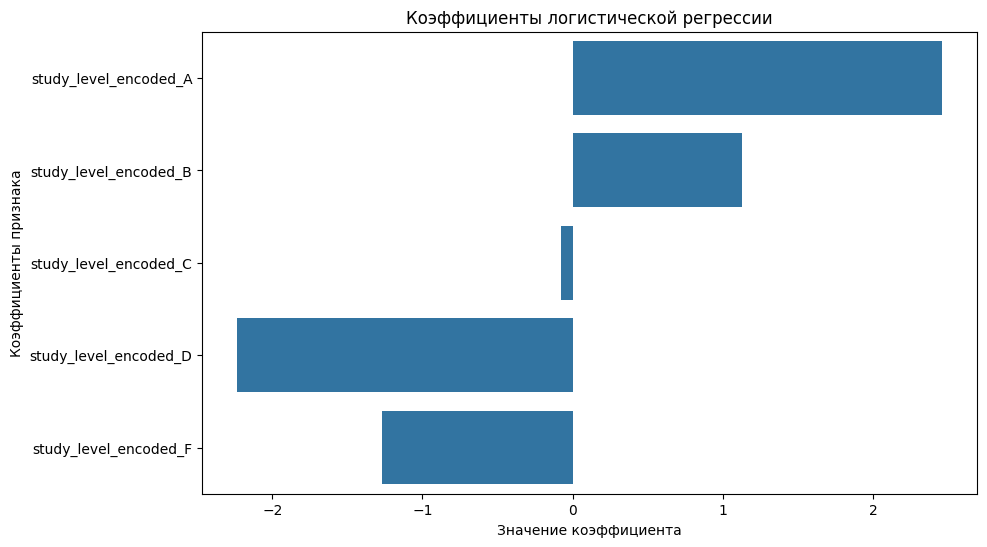

In [35]:
plt.figure(figsize=(10, 6))
y_labels = [f"{X.columns[0]}_{grade}" for grade in ['A', 'B', 'C', 'D', 'F']]
sns.barplot(x=model.coef_.flatten(), y=y_labels, orient="h")
plt.xlabel("Значение коэффициента")
plt.ylabel("Коэффициенты признака")
plt.title("Коэффициенты логистической регрессии")
plt.show()

Модель логистической регрессии, обученная на признаке study_level, достигла точности 64% и ROC-AUC 0.76. Однако анализ confusion matrix выявил ограничение: модель предсказывает только оценки A и B, полностью игнорируя классы C, D и F.

Коэффициенты модели логичны и показывают, что высокий уровень подготовки снижает вероятность получения низких оценок. Тем не менее, одного признака оказалось недостаточно для адекватного разделения всех 5 категорий оценок.

Модель может использоваться для грубой сортировки студентов на две группы (высокая/низкая успеваемость), но непригодна для точного прогнозирования конкретных оценок.